In [1]:
!gpustat

blade                Thu Jun 17 13:46:30 2021  455.45.01
[0] RTX A6000        | 39'C,   0 % |     0 / 48685 MB |
[1] RTX A6000        | 35'C,   0 % |     0 / 48685 MB |
[2] RTX A6000        | 49'C,   0 % |     0 / 48685 MB |
[3] RTX A6000        | 36'C,   0 % |     0 / 48685 MB |
[4] RTX A6000        | 38'C,   0 % |     0 / 48685 MB |
[5] RTX A6000        | 24'C,   0 % | 44510 / 48685 MB | shyamss(44507M)
[6] RTX A6000        | 24'C,   0 % | 44150 / 48685 MB | shyamss(44147M)
[7] RTX A6000        | 37'C,   3 % |     0 / 48685 MB |


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
import numpy as onp
from numpy import fft
import jax.numpy as np
from jax import random, grad, vmap, jit, lax
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index

from jaxpinns.optimizers import mdmm_adam

import neural_tangents as nt
import operator

from jax.scipy.stats.norm import logpdf, pdf


from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [4]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [5]:
from helpers import *

In [6]:
path = 'different_distribution/'

In [7]:
key = random.PRNGKey(int(time.time() * 100))

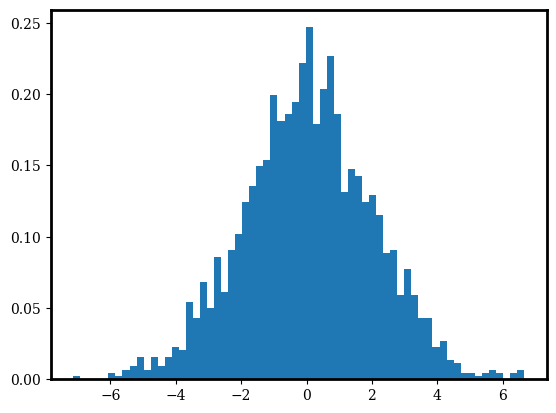

In [8]:
# X = random.uniform(key, shape = (2048, 1), minval = -np.sqrt(3), maxval = np.sqrt(3))
# X = random.normal(key, shape = (2048, 1))*np.sqrt(2) + 1
# X = 2 * random.bernoulli(key, p = 0.5, shape = (2048, 1))
# X = random.exponential(key, shape = (2048, 1))
X = random.normal(key, shape = (2048, 1)) * 2
plt.figure()
h = plt.hist(X.flatten(), bins = 64, density = True)
plt.show()
plt.close()

In [9]:
X = np.sort(X.flatten()).reshape(-1,1)

In [20]:
width = 32
layers = [X.shape[1], *[width for _ in range(8)], 1]
activation = np.tanh
fit_model = MLPRegression(layers, activation = activation)

In [21]:
init_model = initNet(layers[:-1], activation = activation)

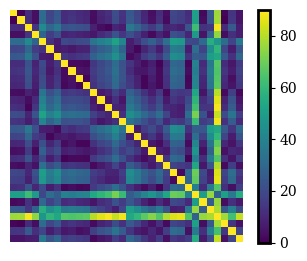

In [22]:
plt.figure(figsize=(4,3))

degree = init_model.angles(init_model.scale_params, init_model.net_params, X)

m = plt.matshow(degree, fignum = 1, vmin = 0, vmax = 90)
plt.axis('off')
c = plt.colorbar(m)
plt.savefig(path + f'{width}_before_train.pdf', dpi = 200)
plt.show()
plt.close()


In [23]:
lr = 5e-3
init_fn, update_fn, get_params = optimizers.adam(lr)
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)

@jit
def step(i, state, X):
    key = random.PRNGKey(i)
    g = grad(init_model.regulated_logSineLoss)(get_params(state), init_model.net_init(key), X, lam = 0.001)
    return update_fn(i, g, state)

def train(init_params, X, nIter = 10000):
    opt_state = init_fn(init_params)

    pbar = trange(nIter)

    for i in pbar:
        opt_state = step(i, opt_state, X)

        if i % 100 == 0:
            params = get_params(opt_state)
            pbar.set_postfix({'Log sine loss': init_model.logSineLoss(get_params(opt_state), init_model.net_init(random.PRNGKey(i)), X)})
    
    return get_params(opt_state)

100%|██████████| 10000/10000 [00:11<00:00, 896.75it/s, Log sine loss=0.29236674]


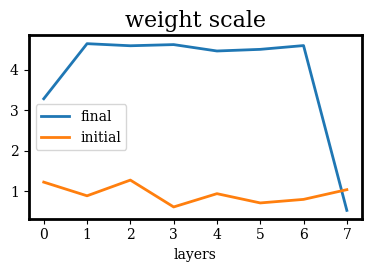

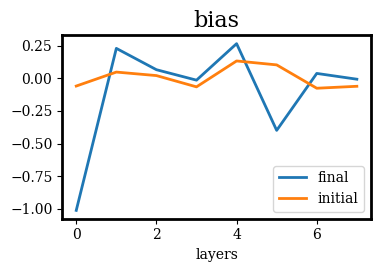

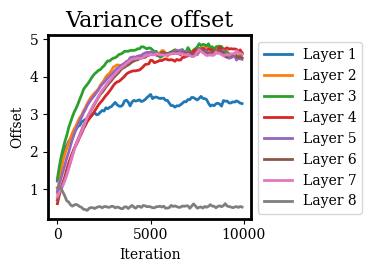

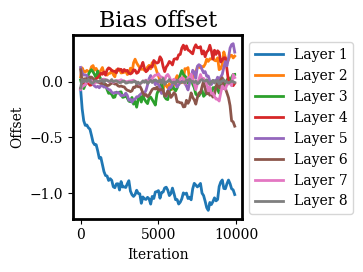

In [24]:
opt_state = init_fn(init_model.scale_params)
init_nIter = 10000
pbar = trange(init_nIter)
scale_stor = []
bias_stor = []

for i in pbar:
    opt_state = step(i, opt_state, X)
    
    if i % 100 == 0:
        params = get_params(opt_state)
        pbar.set_postfix({'Log sine loss': init_model.logSineLoss(get_params(opt_state), init_model.net_init(random.PRNGKey(i)), X)})
        scale_stor.append([w for (w, b) in params])
        bias_stor.append([b for (w, b) in params])
        
scale_params = params
scale_stor = np.array(scale_stor)
bias_stor = np.array(bias_stor)
        
plt.figure(figsize = (4,3))

plt.plot([w_init for w_init, b_init in scale_params], label = 'final')
plt.plot([w_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.xlabel('layers')
plt.legend()
plt.title('weight scale')
plt.tight_layout()

plt.show()
plt.close()

plt.figure(figsize = (4,3))

plt.plot([b_init for w_init, b_init in scale_params], label = 'final')
plt.plot([b_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.xlabel('layers')
plt.legend()
plt.title('bias')
plt.tight_layout()

plt.show()
plt.close()

plt.figure(figsize = (4,3))
for i, s in enumerate(scale_stor.T):
    plt.plot(np.arange(s.shape[0]) * 100, s, label = f'Layer {int(i+1)}')

plt.xlabel('Iteration')
plt.ylabel('Offset')
plt.legend(bbox_to_anchor = (1., 1.))
plt.title('Variance offset')
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize = (4,3))
for i, s in enumerate(bias_stor.T):
    plt.plot(np.arange(s.shape[0]) * 100, s, label = f'Layer {int(i + 1)}')

plt.xlabel('Iteration')
plt.ylabel('Offset')
plt.legend(bbox_to_anchor = (1., 1.))
plt.title('Bias offset')
plt.tight_layout()
plt.show()
plt.close()

In [25]:
Xs = []
Xs.append(random.uniform(key, shape = (2048, 1)))
Xs.append(random.normal(key, shape = (2048, 1)))
Xs.append(random.bernoulli(key, p = 0.5, shape = (2048, 1)))
Xs.append(random.exponential(key, shape = (2048, 1)))
Xs.append(random.beta(key, 0.5, 0.5, shape = (2048, 1)))

Xs_label = [r'$U(0,1)$', r'$N(0,1)$', r'$B(0.5)$', r'$\exp(1)$', r'$\beta(0.5, 0.5)$']

100%|██████████| 10000/10000 [00:09<00:00, 1059.77it/s, Log sine loss=0.28357005]


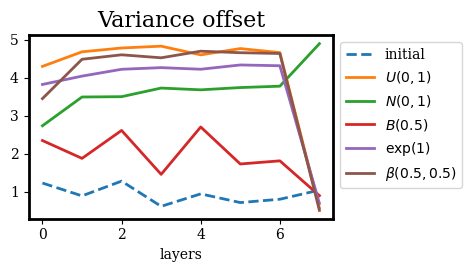

In [26]:
plt.figure(figsize = (5,3))
plt.plot([w_init for w_init, b_init in init_model.scale_params], '--', label = 'initial')

for X, label in zip(Xs, Xs_label):
    scale_params = train(init_model.scale_params, X)

    plt.plot([w_init for w_init, b_init in scale_params], label = label)


plt.xlabel('layers')
plt.legend(bbox_to_anchor = (1., 1.))
plt.title('Variance offset')
plt.tight_layout()

plt.show()
plt.close()




In [27]:
params_list = []
keys = random.split(key, 5)
for i, k in enumerate(keys):
    X = random.normal(k, shape = (2048, 1)) * (i + 1)
    params_list.append(train(init_model.scale_params, X))
    

100%|██████████| 10000/10000 [00:09<00:00, 1054.51it/s, Log sine loss=0.1940497] 


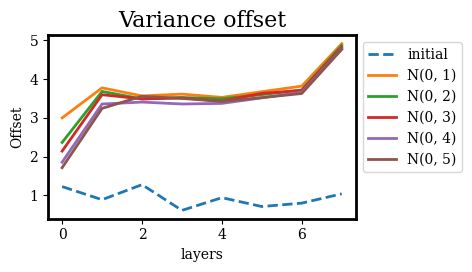

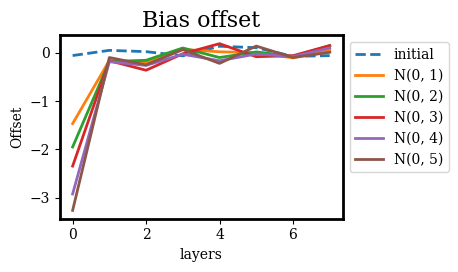

In [30]:
plt.figure(figsize = (5,3))

plt.plot([w_init for w_init, b_init in init_model.scale_params], '--', label = 'initial')

for i, scale_params in enumerate(params_list):
    plt.plot([w_init for w_init, b_init in scale_params], label = f'N(0, {int(i+1)})')

plt.xlabel('layers')
plt.ylabel('Offset')
plt.legend(bbox_to_anchor = (1., 1.))
plt.title('Variance offset')
plt.tight_layout()

plt.show()
plt.close()

plt.figure(figsize = (5,3))

plt.plot([b_init for w_init, b_init in init_model.scale_params], '--', label = 'initial')

for i, scale_params in enumerate(params_list):
    plt.plot([b_init for w_init, b_init in scale_params], label = f'N(0, {int(i+1)})')

plt.xlabel('layers')
plt.ylabel('Offset')
plt.legend(bbox_to_anchor = (1., 1.))
plt.title('Bias offset')
plt.tight_layout()

plt.show()
plt.close()

In [31]:
params_list = []
keys = random.split(key, 5)
for i, k in enumerate(keys):
    X = random.normal(k, shape = (2048, 1)) + i
    params_list.append(train(init_model.scale_params, X))

100%|██████████| 10000/10000 [00:09<00:00, 1035.30it/s, Log sine loss=0.26327437]


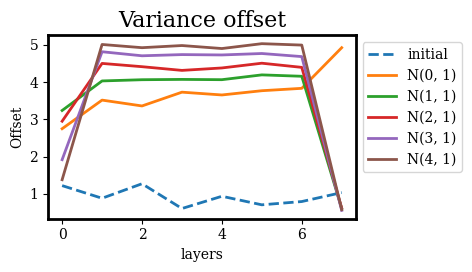

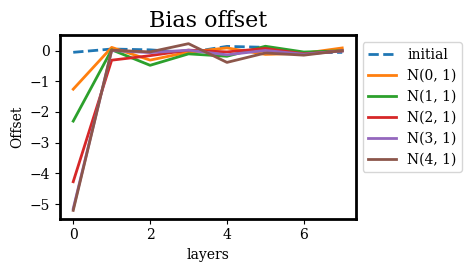

In [32]:
plt.figure(figsize = (5,3))

plt.plot([w_init for w_init, b_init in init_model.scale_params], '--', label = 'initial')

for i, scale_params in enumerate(params_list):
    plt.plot([w_init for w_init, b_init in scale_params], label = f'N({int(i)}, 1)')

plt.xlabel('layers')
plt.ylabel('Offset')
plt.legend(bbox_to_anchor = (1., 1.))
plt.title('Variance offset')
plt.tight_layout()

plt.show()
plt.close()

plt.figure(figsize = (5,3))

plt.plot([b_init for w_init, b_init in init_model.scale_params], '--', label = 'initial')

for i, scale_params in enumerate(params_list):
    plt.plot([b_init for w_init, b_init in scale_params], label = f'N({int(i)}, 1)')

plt.xlabel('layers')
plt.ylabel('Offset')
plt.legend(bbox_to_anchor = (1., 1.))
plt.title('Bias offset')
plt.tight_layout()

plt.show()
plt.close()